In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from plot_evalue_distributions import plot_evalue_histograms, plot_evalue_kde
from complex_i_analysis import cluster_hits_with_strand, generate_subunit_data, classify_complex_types

from config import HMM_ANALYSIS_DIR, GENOME_METADATA_FILE, GENOME_DATASET_FILE

import warnings
warnings.filterwarnings('ignore')

In [2]:
results = pd.read_csv(HMM_ANALYSIS_DIR / "results_unfil.csv")

In [3]:
# Set output directory
output_dir = HMM_ANALYSIS_DIR / "Figures"
output_dir.mkdir(parents=True, exist_ok=True)

# Generate and save plots
# plot_evalue_histograms(results, output_dir)
# plot_evalue_kde(results, output_dir)

In [4]:
# Load datasets using paths from config.py
genomes_dataset = pd.read_csv(GENOME_DATASET_FILE)
genomes_metadata = pd.read_csv(GENOME_METADATA_FILE)

# Merge results with metadata
results = pd.merge(
    genomes_metadata.merge(results), 
    genomes_dataset[['GenomeFile', 'Species', 'Organism']], 
    on='GenomeFile'
)


In [5]:
results.head()

,Accession,Replicon,GenomeFile,SequenceLength(Mb),ProteinAccession,evalue,BitScore,Bias,SequenceDesc,Subunit,Start,End,log10evalue,Species,Organism
0,AP024266.1,Chromosome,GCA_016755935.1_ASM1675593v1_genomic.fna,5.921363,AP024266.1_4313,2.000000e-256,851.8,16.0,# 4576494 # 4578395 # 1 # ID=1_4313;partial=00...,NuoL,4576494,4578395,-255.698970,Mycobacterium intracellulare,Bacteria
1,AP024266.1,Chromosome,GCA_016755935.1_ASM1675593v1_genomic.fna,5.921363,AP024266.1_4308,1.300000e-234,780.4,0.0,# 4571081 # 4573495 # 1 # ID=1_4308;partial=00...,NuoG,4571081,4573495,-233.886057,Mycobacterium intracellulare,Bacteria
2,AP024266.1,Chromosome,GCA_016755935.1_ASM1675593v1_genomic.fna,5.921363,AP024266.1_4307,4.300000e-212,704.1,0.0,# 4569733 # 4571073 # 1 # ID=1_4307;partial=00...,NuoF,4569733,4571073,-211.366532,Mycobacterium intracellulare,Bacteria
3,AP024266.1,Chromosome,GCA_016755935.1_ASM1675593v1_genomic.fna,5.921363,AP024266.1_4314,1.300000e-189,630.2,21.8,# 4578401 # 4579984 # 1 # ID=1_4314;partial=00...,NuoM,4578401,4579984,-188.886057,Mycobacterium intracellulare,Bacteria
4,AP024266.1,Chromosome,GCA_016755935.1_ASM1675593v1_genomic.fna,5.921363,AP024266.1_4315,2.200000e-183,609.6,24.5,# 4579981 # 4581570 # 1 # ID=1_4315;partial=00...,NuoN,4579981,4581570,-182.657577,Mycobacterium intracellulare,Bacteria


In [6]:
results['Species'].nunique()

10460

In [7]:
hits_summaries = (
    results.groupby('Subunit')
    .agg(
        Species=('Species', 'nunique'),
        NoProteinHits=('ProteinAccession', 'nunique'),
        NoGenomes=('GenomeFile', 'nunique')
    )
    .assign(AvgHits=lambda df: df['NoProteinHits'] / df['NoGenomes'])
    .reset_index()
    .sort_values('AvgHits', ascending=False)
)


In [8]:
hits_summaries.head()

,Subunit,Species,NoProteinHits,NoGenomes,AvgHits
8,NuoG,9631,277362,40320,6.879018
10,NuoI,9884,231130,38772,5.961261
13,NuoL,9236,77059,37879,2.034346
7,NuoF,7981,63132,33122,1.906044
5,NuoD,6565,41155,23987,1.715721


In [9]:
combinations = {
    'Nuo14': ['NuoA', 'NuoB', 'NuoC', 'NuoD', 'NuoE', 'NuoF', 'NuoG', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL', 'NuoM', 'NuoN'],
    'Nuo13': ['NuoA', 'NuoB', 'NuoCD', 'NuoE', 'NuoF', 'NuoG', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL', 'NuoM', 'NuoN'],
    'Nuo12': ['NuoA', 'NuoBCD', 'NuoE', 'NuoF', 'NuoG', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL', 'NuoM', 'NuoN'],
}

colors = ["#a5b1c2", "#f7b731", "#20bf6b", "#45aaf2", "#3867d6", "#a55eea", "#0fb9b1", '#4b6584']
labels = ['Nuo-Partial', 'Nuo13', 'Nuo14', 'Nuo14-EFG', 'Nuo13-EFG', 'Nuo14-EF', 'Nuo12', 'Existing Annotation']

complex_colors = dict(zip(labels, colors))

In [11]:
# Define intergenic distance range
intergenic_distances = range(0, 900, 100)

# Extract and sort unique subunits only once
all_subunits = sorted(results['Subunit'].dropna().unique())

# Drop duplicate species-accession pairs once before the loop
unique_species_accessions = results[['Species', 'Accession']].drop_duplicates()

# List to store results efficiently
species_counts_by_distance = []

for distance in tqdm(intergenic_distances, desc="Processing intergenic distances"):
    # Apply clustering for the given intergenic distance
    clustered_results = results.groupby('Accession', group_keys=False).apply(
        cluster_hits_with_strand, intergenic_distance=distance
    ).reset_index(drop=True)

    # Generate count and boolean tables
    count_table, bool_table = generate_subunit_data(clustered_results, all_subunits)
    bool_table.drop_duplicates(inplace=True)

    # Classify complex types
    classified_table = classify_complex_types(bool_table, combinations, all_subunits)

    # Merge with precomputed species-accession pairs
    classified_table = classified_table.merge(unique_species_accessions, on="Accession", how="left")

    # Count unique species per variation
    variation_counts = classified_table.groupby('Variation')['Species'].nunique()

    # Identify complete complex species and partial complex species
    comp_classified_table = classified_table[classified_table['Variation'] != 'Nuo-Partial']
    comp_species = comp_classified_table['Species'].nunique()

    # Find partial species by excluding those already in the complete set
    partial_species = classified_table.loc[
        ~classified_table['Species'].isin(comp_classified_table['Species']), 'Species'
    ].nunique()

    # Store results
    species_counts_by_distance.append({
        'Intergenic_Distance': distance,
        'Nuo14': variation_counts.get('Nuo14', 0),
        'Nuo13': variation_counts.get('Nuo13', 0),
        'Nuo12': variation_counts.get('Nuo12', 0),
        'NuoCore': comp_species,
        'Nuo-Partial': partial_species
    })

# Convert to DataFrame
species_counts_df = pd.DataFrame(species_counts_by_distance)


Processing intergenic distances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [03:32<00:00, 23.63s/it]


In [14]:
species_counts_df.to_csv(HMM_ANALYSIS_DIR / "intergenic_dist_data.csv", index=False)

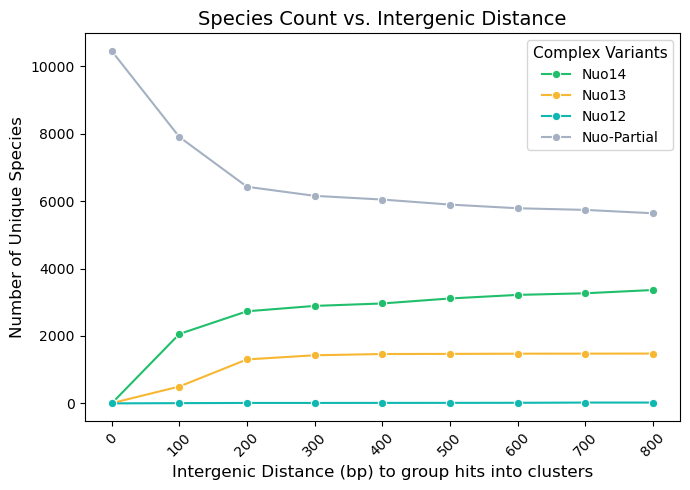

In [12]:
# Set up the figure
plt.figure(figsize=(7, 5))

# Define colors for better readability
colors = {"Nuo14": "#20bf6b", "Nuo13": "#f7b731", "Nuo12": "#0fb9b1", "Nuo-Partial": "#a5b1c2"}

# Plot all variations in a single loop
for variation, color in colors.items():
    sns.lineplot(data=species_counts_df, x='Intergenic_Distance', y=variation, label=variation, color=color, marker="o")

# Improve labels and formatting
plt.xlabel('Intergenic Distance (bp) to group hits into clusters', fontsize=12)
plt.ylabel('Number of Unique Species', fontsize=12)
plt.title('Species Count vs. Intergenic Distance', fontsize=14)
plt.xticks(species_counts_df['Intergenic_Distance'], rotation=45)
# plt.grid(True, linestyle="--", alpha=0.125)
plt.legend(title="Complex Variants", fontsize=10, title_fontsize=11)

plt.tight_layout()

plt.savefig(output_dir / "intergenic_dist_clusters_unfil_hits_01.png", dpi=500)
plt.savefig(output_dir / "intergenic_dist_clusters_unfil_hits_01.pdf", format='pdf', dpi=500)

# Show the plot
plt.show()


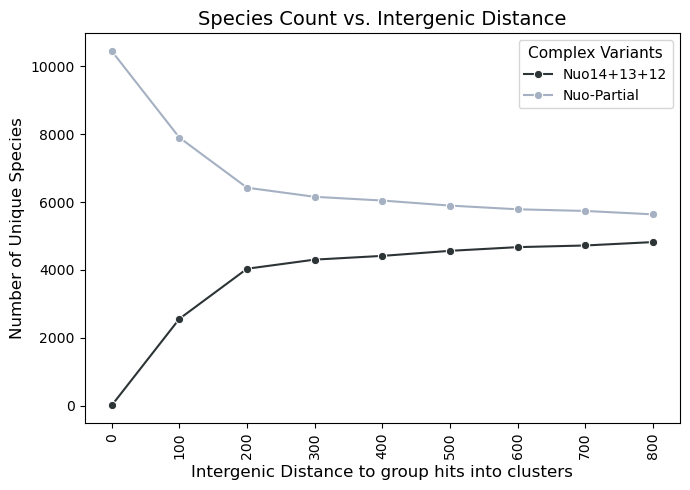

In [13]:
# Set up the figure
plt.figure(figsize=(7, 5))

# Define colors for better readability
colors = {"Nuo14": "#20bf6b", "Nuo13": "#f7b731", "Nuo12": "#0fb9b1"}

# Plot all variations in a single loop
sns.lineplot(data=species_counts_df, x='Intergenic_Distance', y='NuoCore', label='Nuo14+13+12', color='#2d3436', marker="o")
sns.lineplot(data=species_counts_df, x='Intergenic_Distance', y='Nuo-Partial', label='Nuo-Partial', color='#a5b1c2', marker="o")

# Improve labels and formatting
plt.xlabel('Intergenic Distance to group hits into clusters', fontsize=12)
plt.ylabel('Number of Unique Species', fontsize=12)
plt.title('Species Count vs. Intergenic Distance', fontsize=14)
plt.xticks(species_counts_df['Intergenic_Distance'], rotation=90)
# plt.grid(True, linestyle="--", alpha=0.125)
plt.legend(title="Complex Variants", fontsize=10, title_fontsize=11)

plt.tight_layout()

plt.savefig(output_dir / "intergenic_dist_clusters_unfil_hits_02.png", dpi=500)
plt.savefig(output_dir / "intergenic_dist_clusters_unfil_hits_02.pdf", format='pdf', dpi=500)
# Show the plot
plt.show()


In [15]:
species_counts_df

,Intergenic_Distance,Nuo14,Nuo13,Nuo12,NuoCore,Nuo-Partial
0,0,0,6,0,6,10454
1,100,2059,500,7,2558,7902
2,200,2732,1304,13,4035,6425
3,300,2891,1427,13,4304,6156
4,400,2964,1464,14,4414,6046
5,500,3112,1468,15,4563,5897
6,600,3218,1474,17,4672,5788
7,700,3266,1475,24,4721,5739
8,800,3363,1478,24,4821,5639
